## Supplementary Figure 6

Plots for use in showing 6-mers and preference scores for use in creating figures for concatinated k-mers. 

### Overview

**Supplementary Figure 6A**: Comparison of 6-mers and 7-mers

**Supplementary Figure 6B**: OLS and preference scores for the k-mers


### File Input and Output

This notebook covers the analysis for the CPD and 6-4PP antibody k-mer replicates. It takes as **input** the following files:


| Input File | Associated Figure |
| --- | --- |
| CREB1_WC_ID0_7of9mers_1111111.txt | Supplementary Figure 6A |
| CREB1_UV_ID1_7of9mers_1111111.txt | Supplementary Figure 6A |
| EGR1_WC_ID2_7of9mers_1111111.txt | Supplementary Figure 6A |
| EGR1_UV_ID3_7of9mers_1111111.txt | Supplementary Figure 6A |
| OLS_CREB1_0_1_Escore.txt | Supplementary Figure 6A-B |
| OLS_EGR1_2_3_Escore.txt | Supplementary Figure 6A-B |

And generates the following **output**:


| Output File | Associated Figure | Desciption |
| --- | --- | --- |
| Fig_S6A.png | Supplementary Figure 6A | The four scatterplots as a single image |
| Fig_S6B_Replicates.svg | Supplementary Figure 6B | Left scatterplot in the figure for 6-mer replicates |
| Fig_S6B_Comparison.svg | Supplementary Figure 6B | Right scatterplot in the figure for 6-mer OLS classification |



#### Imports and Global Variables

In [1]:
import os

from bokeh.io import export_svg, output_notebook
from bokeh.plotting import figure, output_file, ColumnDataSource, show
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

KMER_7MER = "../../Data/Kmer_Files"
KMER_6MER = "../../Design/Concatinated_Kmers_Design/Data"
FIGURE_S6A_7MER_INPUT = ((0,
                          f"{KMER_7MER}/CREB1_WC_ID0_7of9mers_1111111.txt",
                          f"{KMER_7MER}/CREB1_UV_ID1_7of9mers_1111111.txt" ),
                         (1,
                          f"{KMER_7MER}/EGR1_WC_ID2_7of9mers_1111111.txt",
                          f"{KMER_7MER}/EGR1_UV_ID3_7of9mers_1111111.txt"))
FIGURE_S6A_6MER_INPUT = ((0,
                          f"{KMER_6MER}/CREB1_0_1/OLS_CREB1_0_1_Escore.txt"),
                         (1, 
                          f"{KMER_6MER}/EGR1_2_3/OLS_EGR1_2_3_Escore.txt"))
FIGURE_S6B_INPUT = f"{KMER_6MER}/CREB1_0_1/OLS_CREB1_0_1_Escore.txt"
OUTPUT = "../Figure_S6"

In [2]:
os.makedirs(OUTPUT, exist_ok=True)

### Supplementary Figure 6A


#### (1) Functions

In [3]:
def add_escore_scatterplot(plot_df, x, y, ax):
    """Add a scatterplot to an ax object in a matplotlib figure."""
    sns.scatterplot(x=x,
                    y=y,
                    data=plot_df,
                    ax=ax,
                    linewidth=0,
                    color="black",
                    legend=False,
                    s=5)
    ax.set_xlim(-0.52, 0.52)
    ax.set_ylim(-0.52, 0.52)
    plot_ticks = (-0.4, 0, 0.4)
    ax.set_xticks(plot_ticks)
    ax.set_yticks(plot_ticks)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set(adjustable='box', aspect='equal')

#### (2) Analysis

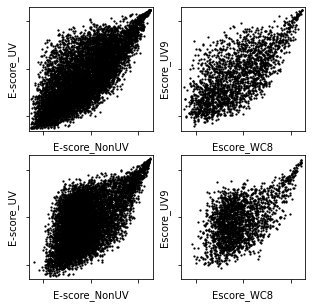

In [4]:
# Setup figure
fig, ax_array = plt.subplots(2, 2)
fig.set_size_inches(5, 5)

# Plot 7-mer data
for plot_pos, nonuv, uv in FIGURE_S6A_7MER_INPUT:
    # Read k-mer files for each condition
    non_uv_df = pd.read_csv(nonuv, sep="\t")
    non_uv_df = non_uv_df[["7-mer", "E-score"]]
    uv_df = pd.read_csv(uv, sep = '\t')
    uv_df = uv_df[["7-mer", "E-score"]]
    # Merge into a single dataframe
    comparison = pd.merge(non_uv_df, uv_df, on="7-mer", suffixes = ("_NonUV", "_UV"))
    add_escore_scatterplot(comparison, "E-score_NonUV", "E-score_UV", ax_array[plot_pos][0])
    
# Plot 6-mer data
for plot_pos, file in FIGURE_S6A_6MER_INPUT:
    kmer_df = pd.read_csv(file, sep = '\t', skiprows=7)
    add_escore_scatterplot(kmer_df, "Escore_WC8", "Escore_UV9", ax_array[plot_pos][1])

fig.savefig(fname=f"{OUTPUT}/Figure_S6A.svg", format='svg')

### Supplementary Figure 6B


#### (1) Functions

In [5]:
def color_from_mpl_palette(palette: str,
                           query_value: float,
                           value_min: float,
                           value_max: float) -> str:
    """Return the hex color code from a matplotlib color palette.
    
    Given a query value, the value range the pallette is being used for, and 
    the name of the matplotlib palette, returns a hex color code as a string for
    the value.
    """
    # Color map object
    color_map = matplotlib.cm.get_cmap(palette)
    # Get normalization of values based on value range
    normalization = matplotlib.colors.Normalize(vmin=value_min, vmax=value_max)
    # Output includes rgb and luminence but only rgb is needed for hex code
    rgb_colors = color_map(normalization(query_value))[:3]
    color = matplotlib.colors.rgb2hex(rgb_colors)
    return color

def colorbar_from_mpl_palette(palette: str,
                           query_value: float,
                           value_min: float,
                           value_max: float) -> str:
    """Return the hex color code from a matplotlib color palette.
    
    Given a query value, the value range the pallette is being used for, and 
    the name of the matplotlib palette, returns a hex color code as a string for
    the value.
    """
    # Color map object
    color_map = matplotlib.cm.get_cmap(palette)
    # Get normalization of values based on value range
    normalization = matplotlib.colors.Normalize(vmin=value_min, vmax=value_max)
    # Output includes rgb and luminence but only rgb is needed for hex code
    cmap = color_map(normalization(query_value))
    return cmap

def ols_scatterplot(x, y, plot_df, color, output):
    p = figure(x_range=(-0.52, 0.52), y_range=(-0.52, 0.52))
    p.circle(x=plot_df[x],
             y=plot_df[y],
             color=color,
            size=6)
    p.line(x=plot_df[x],
           y=plot_df["Confidence_Interval_Upper"],
           color='black',
           line_dash='dashed',
           line_width=2)
    p.line(x=plot_df[x],
           y=plot_df["Confidence_Interval_Lower"],
           color='black',
           line_dash='dashed',
           line_width=2)
    p.toolbar_location = None
    p.xgrid.visible = False
    p.ygrid.visible = False
    p.xaxis.minor_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    p.xaxis.major_label_text_font_size = '0pt'
    p.yaxis.major_label_text_font_size = '0pt'
    p.output_backend='svg'
    export_svg(p, filename=output)

#### (2) Read Input data - Set Color Bar to Lowest Multiple of Absolute Max Preference Score

In [6]:
df = pd.read_csv(FIGURE_S6B_INPUT,
                 sep='\t',
                 skiprows=7)
p_absmax = max(df["Preference_Score"].apply(lambda x: abs(x)))
print("colorbar_edge must be set higher than", p_absmax)
colorbar_edge = 8.5 # Color bar edges, must contain p_absmax

colorbar_edge must be set higher than 8.209002


#### (3) Analysis

In [7]:
# Set colors for datapoints
df["Color"] = df["Preference_Score"].apply(lambda x: color_from_mpl_palette("coolwarm",
                                                                             x,
                                                                             -1 * colorbar_edge,
                                                                             colorbar_edge))
plot_df = df.sort_values(by="Escore_WC8").reset_index()
# Create the left scatterplot of replicate E-scores
ols_scatterplot("Escore_WC8", "Escore_WC9", plot_df, "black", f"{OUTPUT}/Fig_S6B_Replicates.svg")
# Create the right scatterplot of Non-UV vs UV k-mers
ols_scatterplot("Escore_WC8", "Escore_UV9", plot_df, plot_df["Color"], f"{OUTPUT}/Fig_S6B_Comparison.svg")